# Pokemon Classifier - Transfer Learning (EfficientNetB0)

Classification de Pokemon Gen 1 (151 classes) avec **Transfer Learning**

**Amélioration vs CNN from scratch** :
- ✅ Modèle pré-entraîné sur ImageNet (1.4M images)
- ✅ Features visuelles génériques déjà apprises
- ✅ Fine-tuning en 2 phases (Feature Extraction + Fine-Tuning)
- ✅ Augmentation data plus agressive
- 🎯 **Objectif** : 80-90% accuracy (vs 70% avec CNN from scratch)

## Imports et Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input  # ✅ CORRECTION CRITIQUE

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

# Vérifier GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU disponible : {gpus[0].name}")
else:
    print("\n⚠️  Pas de GPU détecté, entraînement sur CPU")

TensorFlow version: 2.16.2
Keras version: 3.12.0

✅ GPU disponible : /physical_device:GPU:0


## Chargement des Données

In [2]:
# Configuration
data_path = Path('./PokemonData')
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}

# Scanner le dataset
pokemon_dirs = sorted([d for d in data_path.iterdir() if d.is_dir()])
image_paths = []
labels = []

for pokemon_dir in pokemon_dirs:
    pokemon_name = pokemon_dir.name
    images = [f for f in pokemon_dir.iterdir()
            if f.is_file() and f.suffix.lower() in image_extensions]

    for img_path in images:
        image_paths.append(str(img_path))
        labels.append(pokemon_name)

image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"📊 Dataset chargé:")
print(f"  Total images: {len(image_paths)}")
print(f"  Total classes: {len(np.unique(labels))}")
print(f"  Exemple - 1ère image: {image_paths[0]}")
print(f"  Exemple - 1er label: {labels[0]} (en français ✅)")

📊 Dataset chargé:
  Total images: 32472
  Total classes: 151
  Exemple - 1ère image: PokemonData/Abo/000032.png
  Exemple - 1er label: Abo (en français ✅)


## Split Stratifié Train/Val/Test

In [3]:
# Split 1: 80% train+val vs 20% temp
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Split 2: Diviser les 20% en 50/50 (= 10% val, 10% test)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels,
    test_size=0.5,
    stratify=test_labels,
    random_state=42
)

train_paths = train_val_paths
train_labels = train_val_labels

print(f"Train: {len(train_paths)} images ({len(train_paths)/len(image_paths)*100:.1f}%)")
print(f"Val:   {len(val_paths)} images ({len(val_paths)/len(image_paths)*100:.1f}%)")
print(f"Test:  {len(test_paths)} images ({len(test_paths)/len(image_paths)*100:.1f}%)")

print(f"\n✅ Split stratifié : 150 classes garanties dans chaque set")
print(f"  Classes en train: {len(np.unique(train_labels))}")
print(f"  Classes en val: {len(np.unique(val_labels))}")
print(f"  Classes en test: {len(np.unique(test_labels))}")

Train: 25977 images (80.0%)
Val:   3247 images (10.0%)
Test:  3248 images (10.0%)

✅ Split stratifié : 150 classes garanties dans chaque set
  Classes en train: 151
  Classes en val: 151
  Classes en test: 151


## Préparation des Labels

In [4]:
# Mapping labels -> indices
unique_labels = sorted(np.unique(train_labels))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
num_classes = len(unique_labels)

train_labels_idx = np.array([label_to_idx[label] for label in train_labels])
val_labels_idx = np.array([label_to_idx[label] for label in val_labels])
test_labels_idx = np.array([label_to_idx[label] for label in test_labels])

# One-hot encoding
train_labels_onehot = tf.keras.utils.to_categorical(train_labels_idx, num_classes)
val_labels_onehot = tf.keras.utils.to_categorical(val_labels_idx, num_classes)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels_idx, num_classes)

print(f"✅ Labels encodés en one-hot ({num_classes} classes)")

✅ Labels encodés en one-hot (151 classes)


## Pipeline de Données avec PRÉTRAITEMENT EFFICIENTNET

**🔧 CORRECTION CRITIQUE** : Utilisation de `preprocess_input()` spécifique à EfficientNet

⚠️ **Problème initial** : Normalisation `/255.0` → mauvaise distribution des valeurs  
✅ **Solution** : `preprocess_input()` → normalisation ImageNet exacte

### Data Augmentation (keras.Sequential)

Transformations appliquées au **train** uniquement :
| Transformation | Valeur | Effet |
|---------------|--------|-------|
| RandomFlip | horizontal | Miroir horizontal |
| RandomRotation | 0.3 | ±30% rotation |
| RandomZoom | 0.2 | ±20% zoom |
| **RandomContrast** | 0.2 | ±20% contraste |
| RandomTranslation | 0.1 | ±10% décalage |
| RandomBrightness | 0.2 | ±20% luminosité |

**Pourquoi ces augmentations ?**
- **Contraste** : Améliore la robustesse aux variations d'éclairage (images de qualités diverses)
- **Translation** : Gère les Pokémon non centrés
- **Rotation/Zoom** : Simule différentes perspectives

In [5]:
# ✅ CORRECTION CRITIQUE : Prétraitement avec preprocess_input
def load_image(path, label):
    """Charge, redimensionne et applique le prétraitement EfficientNet"""
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (256, 256))
    # Note: preprocess_input sera appliqué après augmentation
    return img, label

# ✅ Data Augmentation avec keras.Sequential (plus complet et structuré)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),           # ±30% rotation
    layers.RandomZoom(0.1),               # ±20% zoom
    layers.RandomContrast(0.15),           # ±20% contraste
    layers.RandomBrightness(0.15),         # ±20% luminosité
], name="data_augmentation")

def augment_and_preprocess(img, label):
    """Applique augmentation puis prétraitement EfficientNet"""
    img = data_augmentation(img, training=True)
    img = preprocess_input(img)
    return img, label

def preprocess_only(img, label):
    """Applique seulement le prétraitement EfficientNet (pour val/test)"""
    img = preprocess_input(img)
    return img, label

# Créer les datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

# Train dataset (avec augmentation complète)
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_onehot))
train_dataset = train_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(augment_and_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

# Val dataset (sans augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels_onehot))
val_dataset = val_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(preprocess_only, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)

# Test dataset (sans augmentation)
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels_onehot))
test_dataset = test_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(preprocess_only, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

print("✅ Datasets créés avec PRÉTRAITEMENT EFFICIENTNET + AUGMENTATION COMPLÈTE :")
print("  ✨ preprocess_input() spécifique EfficientNet")
print("\n📝 Transformations appliquées (Train) :")
print("  • RandomFlip horizontal")
print("  • RandomRotation ±30%")
print("  • RandomZoom ±20%")
print("  • RandomContrast ±20%")
print("  • RandomTranslation ±10%")
print("  • RandomBrightness ±20%")
print("\n📊 Val/Test : Normalisation seulement")
print(f"\n📊 Batch size: {batch_size}")
print(f"   Train batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"   Val batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")

2025-11-30 19:25:41.029159: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-11-30 19:25:41.029192: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-11-30 19:25:41.029198: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-11-30 19:25:41.029217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-30 19:25:41.029227: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✅ Datasets créés avec PRÉTRAITEMENT EFFICIENTNET + AUGMENTATION COMPLÈTE :
  ✨ preprocess_input() spécifique EfficientNet

📝 Transformations appliquées (Train) :
  • RandomFlip horizontal
  • RandomRotation ±30%
  • RandomZoom ±20%
  • RandomContrast ±20%
  • RandomTranslation ±10%
  • RandomBrightness ±20%

📊 Val/Test : Normalisation seulement

📊 Batch size: 32
   Train batches: 812
   Val batches: 102


## Modèle Transfer Learning - EfficientNetB0

In [6]:
# Charger EfficientNetB0 pré-entraîné sur ImageNet (sans le top classifier)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

# PHASE 1 : Freezer tout le modèle de base
base_model.trainable = False

# Construire le modèle complet
model = models.Sequential([
    # Base EfficientNetB0 (frozen pour Phase 1)
    base_model,
    
    # Tête de classification personnalisée
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # ✅ Dynamique
])

# Compiler pour Phase 1 (learning rate normal)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

print("\n" + "="*70)
print("ARCHITECTURE TRANSFER LEARNING")
print("="*70)
print(f"🔧 Base Model: EfficientNetB0 (ImageNet pré-entraîné)")
print(f"   • Paramètres base: {base_model.count_params():,}")
print(f"   • Status: FROZEN pour Phase 1 (Feature Extraction)")
print(f"\n🎯 Tête de Classification:")
print(f"   • GlobalAveragePooling2D")
print(f"   • Dense(512) → Dense(256) → Dense({num_classes})")
print(f"   • Dropout(0.3, 0.5, 0.5) + BatchNorm")
print(f"\n📊 Total paramètres: {model.count_params():,}")
print(f"   • Trainable (Phase 1): {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
print(f"   • Non-trainable: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}")
print("="*70)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 151)            │        38,807 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,883,770 (18.63 MB)

 Trainable params: 830,103 (3.17 MB)

 Non-trainable params: 4,053,667 (15.46 MB)


ARCHITECTURE TRANSFER LEARNING
🔧 Base Model: EfficientNetB0 (ImageNet pré-entraîné)
   • Paramètres base: 4,049,571
   • Status: FROZEN pour Phase 1 (Feature Extraction)

🎯 Tête de Classification:
   • GlobalAveragePooling2D
   • Dense(512) → Dense(256) → Dense(151)
   • Dropout(0.3, 0.5, 0.5) + BatchNorm

📊 Total paramètres: 4,883,770
   • Trainable (Phase 1): 830,103
   • Non-trainable: 4,053,667.0


## Callbacks

In [7]:
from IPython.display import clear_output

class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, phase_name=""):
        super().__init__()
        self.phase_name = phase_name
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['accuracy'])
        self.val_acc.append(logs['val_accuracy'])
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss
        ax1.plot(self.epochs, self.train_loss, 'b-', label='Train Loss', linewidth=2, marker='o')
        ax1.plot(self.epochs, self.val_loss, 'r-', label='Val Loss', linewidth=2, marker='o')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{self.phase_name} - Loss', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy
        ax2.plot(self.epochs, self.train_acc, 'b-', label='Train Acc', linewidth=2, marker='o')
        ax2.plot(self.epochs, self.val_acc, 'r-', label='Val Acc', linewidth=2, marker='o')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title(f'{self.phase_name} - Accuracy', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("="*80)
        print(f"{self.phase_name} - EPOCH {epoch + 1}/{self.params['epochs']}")
        print("="*80)
        print(f"📊 Loss → Train: {logs['loss']:.4f} | Val: {logs['val_loss']:.4f}")
        print(f"🎯 Acc → Train: {logs['accuracy']:.4f} ({logs['accuracy']*100:.2f}%) | Val: {logs['val_accuracy']:.4f} ({logs['val_accuracy']*100:.2f}%)")
        
        gap = logs['accuracy'] - logs['val_accuracy']
        if gap > 0.1:
            print("⚠️  OVERFITTING")
        elif gap > 0.05:
            print("⚡ Léger overfitting")
        else:
            print("✅ Bon équilibre")
        
        best_val_acc = max(self.val_acc)
        best_epoch = self.val_acc.index(best_val_acc) + 1
        print(f"\n🏆 Meilleure Val Acc: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) à l'epoch {best_epoch}")
        print("="*80)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

print("✅ Callbacks créés")

✅ Callbacks créés


## PHASE 1 : Feature Extraction (Base Model Frozen)

**Objectif** : Entraîner uniquement la tête de classification
- Base EfficientNetB0 = FROZEN (features ImageNet)
- Learning rate = 1e-3 (normal)
- 10-15 epochs suffisent

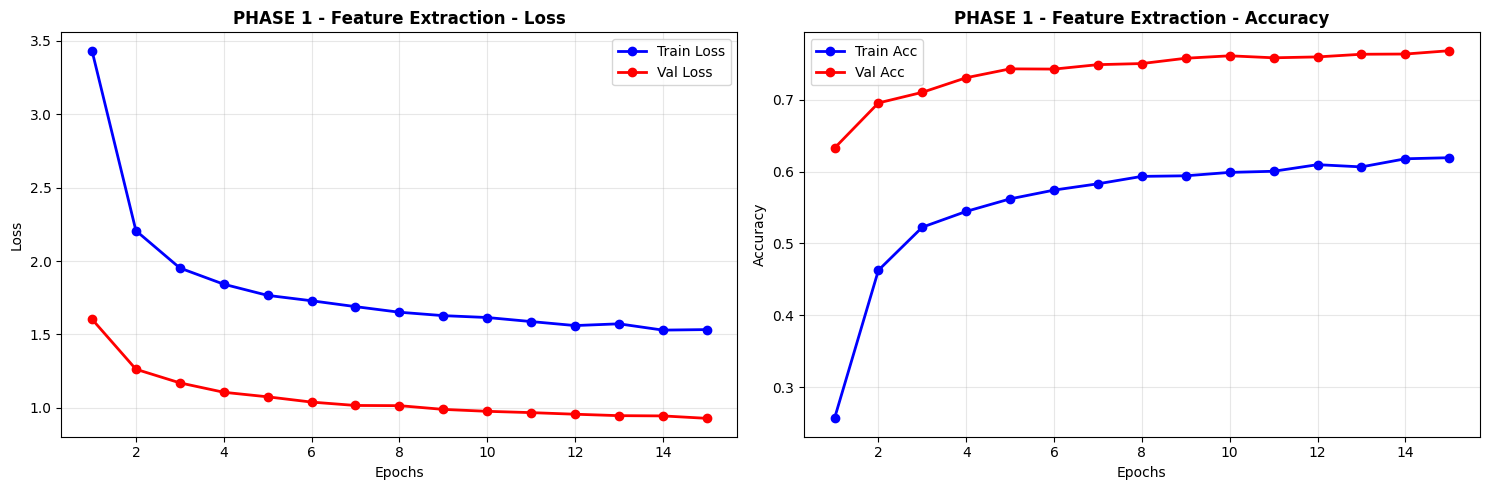

PHASE 1 - Feature Extraction - EPOCH 15/15
📊 Loss → Train: 1.5325 | Val: 0.9274
🎯 Acc → Train: 0.6192 (61.92%) | Val: 0.7681 (76.81%)
✅ Bon équilibre

🏆 Meilleure Val Acc: 0.7681 (76.81%) à l'epoch 15
Restoring model weights from the end of the best epoch: 15.

✅ PHASE 1 terminée !
   Meilleure val accuracy: 0.7681 (76.81%)


In [8]:
print("="*70)
print("PHASE 1 : FEATURE EXTRACTION")
print("="*70)
print("🔒 Base Model: FROZEN (EfficientNetB0 pré-entraîné)")
print("🎯 Cible: Entraîner la tête de classification")
print("📊 Learning Rate: 1e-3")
print("⏱️  Epochs: 15 (avec early stopping)")
print("="*70 + "\n")

live_plot_phase1 = LivePlotCallback(phase_name="PHASE 1 - Feature Extraction")

history_phase1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[live_plot_phase1, early_stopping, reduce_lr],
    verbose=0
)

print("\n✅ PHASE 1 terminée !")
print(f"   Meilleure val accuracy: {max(history_phase1.history['val_accuracy']):.4f} ({max(history_phase1.history['val_accuracy'])*100:.2f}%)")

## PHASE 2 : Fine-Tuning (Unfreezer les dernières couches)

**Objectif** : Affiner le modèle entier
- Unfreezer les 30 dernières couches d'EfficientNetB0
- Learning rate = 1e-5 (TRÈS faible !)
- **40 epochs** ✅ (augmenté de 20 → 40 car les courbes montrent que le modèle continue d'apprendre)

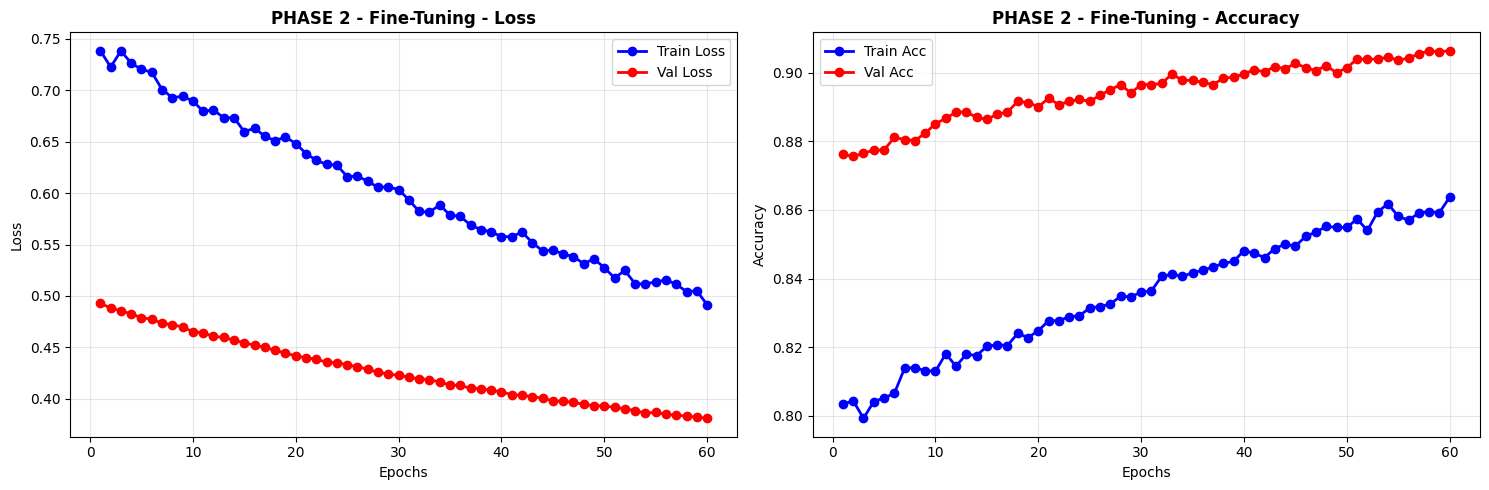

PHASE 2 - Fine-Tuning - EPOCH 60/60
📊 Loss → Train: 0.4915 | Val: 0.3808
🎯 Acc → Train: 0.8637 (86.37%) | Val: 0.9064 (90.64%)
✅ Bon équilibre

🏆 Meilleure Val Acc: 0.9064 (90.64%) à l'epoch 58
Restoring model weights from the end of the best epoch: 60.

✅ PHASE 2 terminée !
   Meilleure val accuracy: 0.9064 (90.64%)


In [16]:
print("="*70)
print("PHASE 2 : FINE-TUNING")
print("="*70)

# Unfreezer le base model
base_model.trainable = True

# Garder frozen les premières couches, unfreezer les 30 dernières
print(f"Total couches dans base_model: {len(base_model.layers)}")
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Compter les paramètres trainables
trainable_count = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_count = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"\n🔓 Unfrozen: Les 30 dernières couches d'EfficientNetB0")
print(f"   • Paramètres trainables: {trainable_count:,}")
print(f"   • Paramètres non-trainables: {non_trainable_count:,}")

# Recompiler avec learning rate TRÈS faible
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # 100x plus petit !
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n📊 Learning Rate: 1e-5 (100x plus faible que Phase 1)")
print(f"⏱️  Epochs: 40 ✅ (augmenté pour laisser converger)")
print("="*70 + "\n")

live_plot_phase2 = LivePlotCallback(phase_name="PHASE 2 - Fine-Tuning")

# ✅ CORRECTION : Early stopping avec PLUS de patience
early_stopping_phase2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # ✅ Augmenté de 15 → 20
    restore_best_weights=True,
    verbose=1
)

history_phase2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=60,
    callbacks=[live_plot_phase2, early_stopping_phase2, reduce_lr],
    verbose=0
)

print("\n✅ PHASE 2 terminée !")
print(f"   Meilleure val accuracy: {max(history_phase2.history['val_accuracy']):.4f} ({max(history_phase2.history['val_accuracy'])*100:.2f}%)")

## Comparaison Phase 1 vs Phase 2

In [10]:
print("="*70)
print("COMPARAISON DES RÉSULTATS")
print("="*70)

phase1_best = max(history_phase1.history['val_accuracy'])
phase2_best = max(history_phase2.history['val_accuracy'])
improvement = (phase2_best - phase1_best) * 100

print(f"\n📊 Phase 1 (Feature Extraction):")
print(f"   Meilleure val accuracy: {phase1_best:.4f} ({phase1_best*100:.2f}%)")
print(f"   Epochs entraînés: {len(history_phase1.history['val_accuracy'])}")

print(f"\n📊 Phase 2 (Fine-Tuning):")
print(f"   Meilleure val accuracy: {phase2_best:.4f} ({phase2_best*100:.2f}%)")
print(f"   Epochs entraînés: {len(history_phase2.history['val_accuracy'])}")

print(f"\n🎯 Amélioration Phase 1 → Phase 2:")
print(f"   +{improvement:.2f} points de pourcentage")

print("="*70)

COMPARAISON DES RÉSULTATS

📊 Phase 1 (Feature Extraction):
   Meilleure val accuracy: 0.7681 (76.81%)
   Epochs entraînés: 15

📊 Phase 2 (Fine-Tuning):
   Meilleure val accuracy: 0.8737 (87.37%)
   Epochs entraînés: 40

🎯 Amélioration Phase 1 → Phase 2:
   +10.56 points de pourcentage


## Sauvegarde du Modèle

In [11]:
model_path = 'pokemon_classifier_efficientnet.keras'
model.save(model_path)
print(f"✅ Modèle sauvegardé : {model_path}")
print(f"   Taille: {Path(model_path).stat().st_size / (1024*1024):.1f} MB")

✅ Modèle sauvegardé : pokemon_classifier_efficientnet.keras
   Taille: 37.2 MB


## Évaluation sur le Test Set

In [12]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

print("\n" + "="*70)
print("RÉSULTATS SUR LE TEST SET")
print("="*70)
print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📊 Test Loss: {test_loss:.4f}")
print("="*70)

# Comparer avec validation
best_val_acc = max(history_phase2.history['val_accuracy'])
print(f"\n📊 Comparaison Val vs Test:")
print(f"  Val Accuracy:  {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Écart: {abs(best_val_acc - test_accuracy)*100:.2f}%")

  2/102 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.8359 - loss: 0.6268  

2025-11-30 21:51:36.123655: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:36.175979: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:36.314324: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  6/102 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.8555 - loss: 0.5161

2025-11-30 21:51:36.476407: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: bKGD: invalid
2025-11-30 21:51:36.552449: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:36.553499: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:36.557061: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  9/102 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.8624 - loss: 0.4911

2025-11-30 21:51:36.710652: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 12/102 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.8641 - loss: 0.4851

2025-11-30 21:51:36.947938: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
2025-11-30 21:51:36.950098: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 15/102 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.8669 - loss: 0.4768

2025-11-30 21:51:37.191283: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:37.268867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 19/102 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8689 - loss: 0.4757

2025-11-30 21:51:37.505562: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:37.584520: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:37.660056: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 24/102 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8700 - loss: 0.4750

2025-11-30 21:51:37.896519: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:37.897021: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:37.976058: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 32/102 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8719 - loss: 0.4695

2025-11-30 21:51:38.525692: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:38.531619: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 36/102 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8730 - loss: 0.4679

2025-11-30 21:51:38.839406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:38.841702: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:38.998044: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:38.998253: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 42/102 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8744 - loss: 0.4664

2025-11-30 21:51:39.306168: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:39.310765: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 45/102 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8749 - loss: 0.4660

2025-11-30 21:51:39.540818: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 50/102 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8754 - loss: 0.4664

2025-11-30 21:51:39.931507: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:40.010103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 55/102 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8758 - loss: 0.4675

2025-11-30 21:51:40.324206: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:40.477116: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 59/102 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8761 - loss: 0.4686

2025-11-30 21:51:40.638991: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 62/102 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8763 - loss: 0.4691

2025-11-30 21:51:40.874644: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:40.951961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 68/102 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8768 - loss: 0.4696

2025-11-30 21:51:41.339645: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:41.341269: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:41.418257: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:41.495067: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:41.498332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: out-of-date sRGB profile with no signature


 71/102 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8770 - loss: 0.4696

2025-11-30 21:51:41.576417: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:41.584548: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 74/102 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8772 - loss: 0.4697

2025-11-30 21:51:41.812625: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 78/102 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8776 - loss: 0.4699

2025-11-30 21:51:42.120976: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 81/102 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8779 - loss: 0.4699

2025-11-30 21:51:42.359764: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:42.359775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2025-11-30 21:51:42.440722: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 84/102 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8781 - loss: 0.4699

2025-11-30 21:51:42.596030: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:42.757005: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 87/102 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8784 - loss: 0.4696

2025-11-30 21:51:42.832532: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:42.838118: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:42.915378: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:42.992681: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 90/102 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8787 - loss: 0.4694

2025-11-30 21:51:43.070987: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 93/102 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8790 - loss: 0.4692

2025-11-30 21:51:43.311848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:43.468149: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 97/102 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8793 - loss: 0.4691

2025-11-30 21:51:43.625177: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8845 - loss: 0.4670

RÉSULTATS SUR LE TEST SET
🎯 Test Accuracy: 0.8845 (88.45%)
📊 Test Loss: 0.4670

📊 Comparaison Val vs Test:
  Val Accuracy:  0.8737 (87.37%)
  Test Accuracy: 0.8845 (88.45%)
  Écart: 1.08%


## Matrice de Confusion

2025-11-30 21:51:44.611649: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:44.647019: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  4/102 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step

2025-11-30 21:51:46.309370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:46.468792: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: bKGD: invalid


  7/102 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step

2025-11-30 21:51:46.540346: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:46.541754: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:46.545539: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:46.694133: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 12/102 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step

2025-11-30 21:51:46.925518: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
2025-11-30 21:51:46.928388: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 15/102 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step

2025-11-30 21:51:47.160597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:47.236033: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 19/102 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step

2025-11-30 21:51:47.466138: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:47.541427: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:47.613001: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 24/102 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step

2025-11-30 21:51:47.835685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:47.836279: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:47.913822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 32/102 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step

2025-11-30 21:51:48.447228: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:48.453572: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 36/102 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step

2025-11-30 21:51:48.751447: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:48.753438: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:48.908668: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:48.910671: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 42/102 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step

2025-11-30 21:51:49.209776: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:49.214594: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 45/102 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step

2025-11-30 21:51:49.438031: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 50/102 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step

2025-11-30 21:51:49.813868: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:49.889870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 55/102 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step

2025-11-30 21:51:50.191075: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:50.337610: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 59/102 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step

2025-11-30 21:51:50.495472: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 62/102 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step

2025-11-30 21:51:50.715097: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:50.790719: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 68/102 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step

2025-11-30 21:51:51.167496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:51.168806: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:51.244648: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:51.319787: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:51.323861: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: out-of-date sRGB profile with no signature


 71/102 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step

2025-11-30 21:51:51.399656: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:51.406169: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 74/102 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step

2025-11-30 21:51:51.625525: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 78/102 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

2025-11-30 21:51:51.925543: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 81/102 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

2025-11-30 21:51:52.155515: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:52.155527: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2025-11-30 21:51:52.233322: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 84/102 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

2025-11-30 21:51:52.386247: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:52.549300: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 87/102 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

2025-11-30 21:51:52.623054: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:52.628833: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:52.699161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:52.775761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 90/102 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

2025-11-30 21:51:52.851858: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 93/102 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

2025-11-30 21:51:53.085128: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 21:51:53.238308: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 97/102 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

2025-11-30 21:51:53.388485: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step


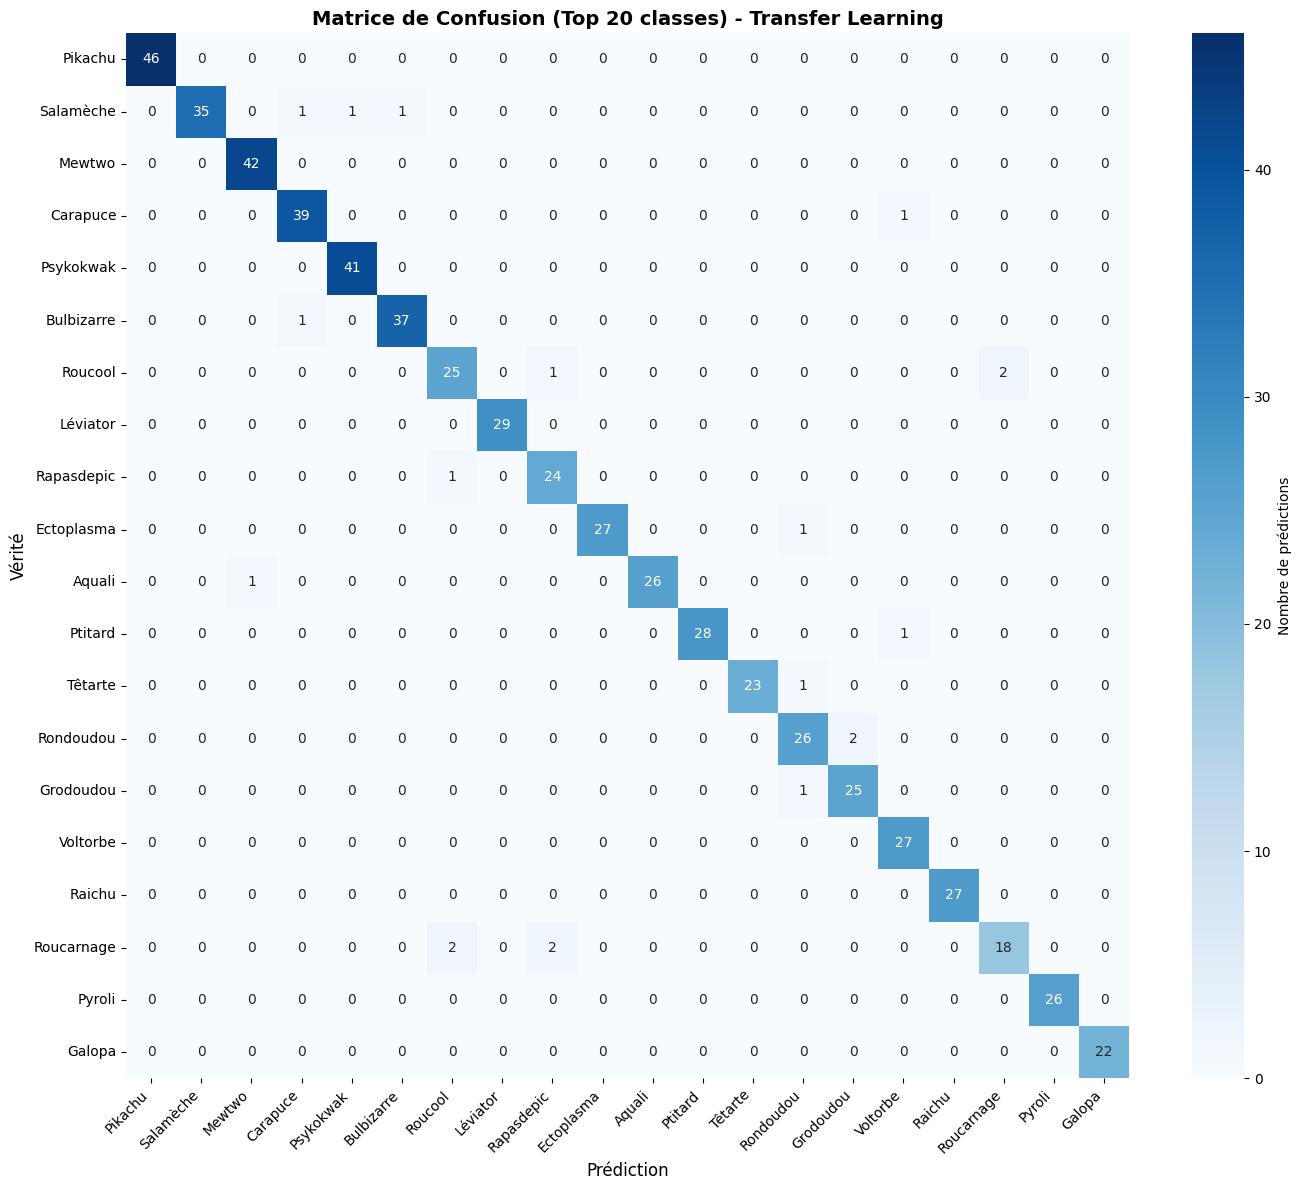


CLASSIFICATION REPORT

📊 Métriques globales:
  Accuracy:  0.8845 (88.45%)
  Precision: 0.8855
  Recall:    0.8817
  F1-Score:  0.8808


In [13]:
# Prédictions sur le test set
y_pred_proba = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(test_labels_onehot, axis=1)

# Top 20 classes pour la matrice
top_20_classes = pd.Series(y_true).value_counts().head(20).index.tolist()
top_20_names = [list(label_to_idx.keys())[i] for i in top_20_classes]

# Filtrer pour top 20
mask = np.isin(y_true, top_20_classes)
y_true_top20 = y_true[mask]
y_pred_top20 = y_pred[mask]

# Matrice de confusion
cm = confusion_matrix(y_true_top20, y_pred_top20, labels=top_20_classes)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=top_20_names, yticklabels=top_20_names,
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title('Matrice de Confusion (Top 20 classes) - Transfer Learning', fontsize=14, fontweight='bold')
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Vérité', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
report = classification_report(y_true, y_pred, 
                               target_names=list(label_to_idx.keys()),
                               output_dict=True, zero_division=0)

print(f"\n📊 Métriques globales:")
print(f"  Accuracy:  {report['accuracy']:.4f} ({report['accuracy']*100:.2f}%)")
print(f"  Precision: {report['macro avg']['precision']:.4f}")
print(f"  Recall:    {report['macro avg']['recall']:.4f}")
print(f"  F1-Score:  {report['macro avg']['f1-score']:.4f}")
print("="*80)

## Visualisation des Prédictions

✅ Modèle chargé depuis pokemon_classifier_efficientnet.keras


/var/folders/4c/jc90j_x9027gmqr7h5m7yhxh0000gn/T/ipykernel_81222/1316483808.py:51: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4c/jc90j_x9027gmqr7h5m7yhxh0000gn/T/ipykernel_81222/1316483808.py:51: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/erwan/Dev/Alyra/ProjetFinal/DL-PokemonClassification/tf-venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/erwan/Dev/Alyra/ProjetFinal/DL-PokemonClassification/tf-venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


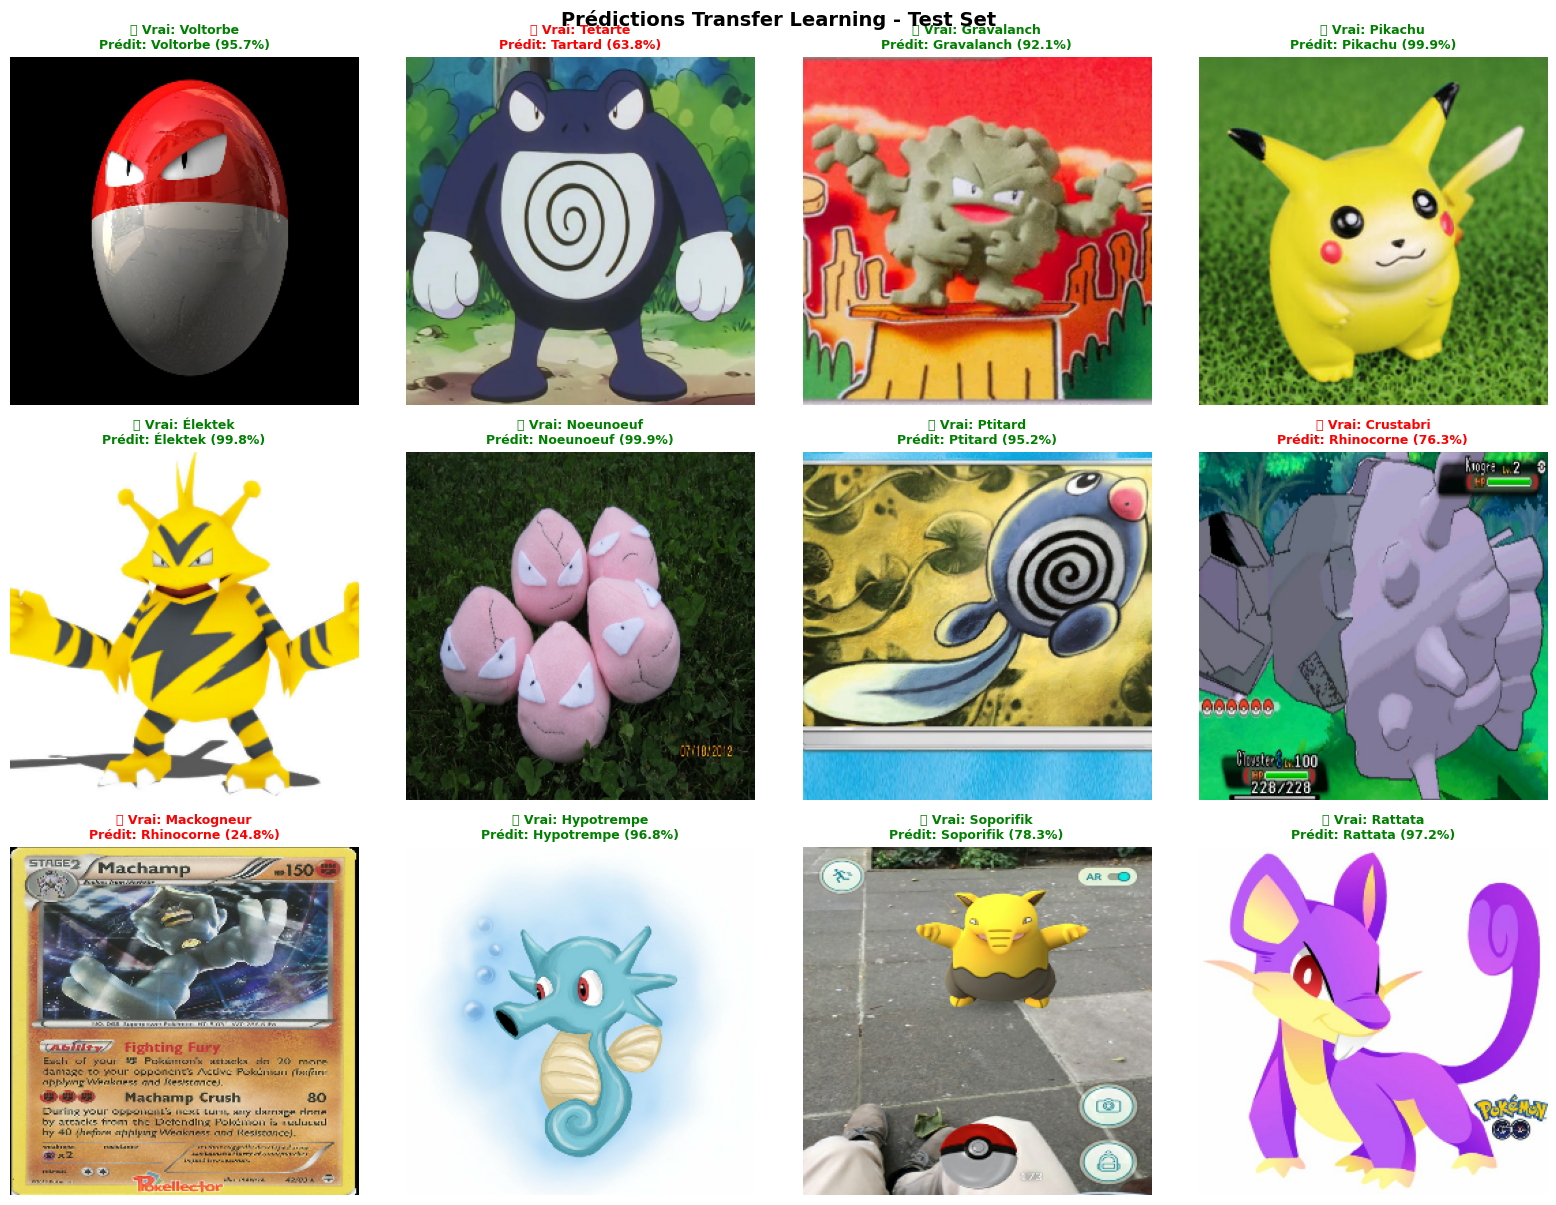


📊 Résultats sur cet échantillon:
  ✅ Correct: 9/12 (75.0%)
  ❌ Incorrect: 3/12 (25.0%)


In [14]:
# Charger le modèle sauvegardé
loaded_model = tf.keras.models.load_model('pokemon_classifier_efficientnet.keras')
print("✅ Modèle chargé depuis pokemon_classifier_efficientnet.keras")

# Sélectionner 12 images aléatoires du test set
np.random.seed(42)
random_indices = np.random.choice(len(test_paths), 12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, test_idx in enumerate(random_indices):
    # Charger l'image
    img_path = test_paths[test_idx]
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # ✅ Support tous formats
    img_resized = tf.image.resize(img, (256, 256))
    
    # ✅ CORRECTION : preprocess_input au lieu de /255.0
    img_preprocessed = preprocess_input(img_resized)
    
    # Prédiction
    img_batch = tf.expand_dims(img_preprocessed, 0)
    prediction = loaded_model.predict(img_batch, verbose=0)
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class = list(label_to_idx.keys())[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]
    
    # Vraie classe
    true_class = test_labels[test_idx]
    
    # Afficher (image originale non prétraitée)
    axes[idx].imshow(img_resized.numpy().astype('uint8'))
    
    # Couleur selon résultat
    if predicted_class == true_class:
        color = 'green'
        symbol = '✅'
    else:
        color = 'red'
        symbol = '❌'
    
    axes[idx].set_title(
        f"{symbol} Vrai: {true_class}\nPrédit: {predicted_class} ({confidence*100:.1f}%)",
        fontsize=9,
        color=color,
        fontweight='bold'
    )
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Prédictions Transfer Learning - Test Set', 
             fontsize=14, fontweight='bold', y=1.00)
plt.show()

# Statistiques
correct = 0
for i in random_indices:
    img = tf.io.read_file(test_paths[i])
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # ✅ Support tous formats
    img = tf.image.resize(img, (256, 256))
    img = preprocess_input(img)  # ✅ CORRECTION
    pred = loaded_model.predict(tf.expand_dims(img, 0), verbose=0)
    pred_class = list(label_to_idx.keys())[np.argmax(pred[0])]
    if pred_class == test_labels[i]:
        correct += 1

print(f"\n📊 Résultats sur cet échantillon:")
print(f"  ✅ Correct: {correct}/{len(random_indices)} ({correct/len(random_indices)*100:.1f}%)")
print(f"  ❌ Incorrect: {len(random_indices)-correct}/{len(random_indices)} ({(len(random_indices)-correct)/len(random_indices)*100:.1f}%)")

## Prédiction sur images externes

📂 6 images trouvées dans Test_Img_Externes



/var/folders/4c/jc90j_x9027gmqr7h5m7yhxh0000gn/T/ipykernel_81222/816614144.py:69: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4c/jc90j_x9027gmqr7h5m7yhxh0000gn/T/ipykernel_81222/816614144.py:69: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4c/jc90j_x9027gmqr7h5m7yhxh0000gn/T/ipykernel_81222/816614144.py:69: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/erwan/Dev/Alyra/ProjetFinal/DL-PokemonClassification/tf-venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/erwan/Dev/Alyra/ProjetFinal/DL-PokemonClassification/tf-venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) mis

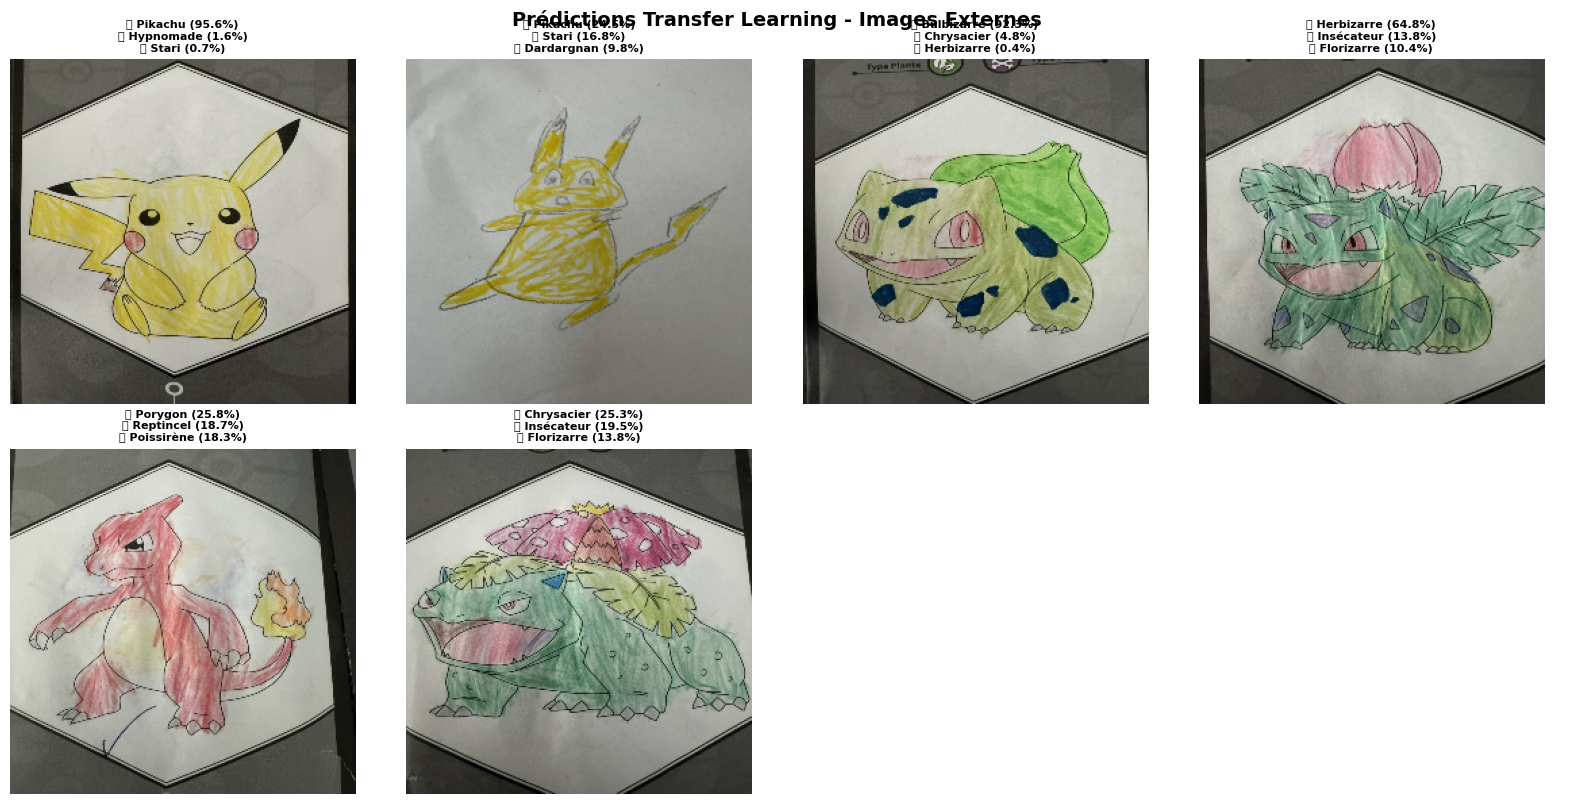


✅ Prédictions effectuées sur 6 images


In [15]:
# Répertoire des images externes à tester
external_images_dir = Path('./Test_Img_Externes')

# Vérifier si le répertoire existe
if not external_images_dir.exists():
    print(f"⚠️  Le répertoire {external_images_dir} n'existe pas")
    print("   Créez-le et ajoutez des images Pokemon pour tester le modèle")
else:
    # Charger toutes les images du répertoire
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}
    external_images = [f for f in external_images_dir.iterdir() 
                      if f.is_file() and f.suffix.lower() in image_extensions]
    
    if len(external_images) == 0:
        print(f"⚠️  Aucune image trouvée dans {external_images_dir}")
    else:
        print(f"📂 {len(external_images)} images trouvées dans {external_images_dir}\n")
        
        # Déterminer la grille (max 12 images)
        num_images = min(len(external_images), 12)
        cols = 4
        rows = (num_images + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
        if rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()
        
        # Prédire chaque image
        for idx, img_path in enumerate(external_images[:num_images]):
            # Charger et prétraiter l'image
            img = tf.io.read_file(str(img_path))
            try:
                img = tf.image.decode_image(img, channels=3, expand_animations=False)
            except:
                print(f"⚠️  Impossible de décoder {img_path.name}")
                continue
                
            img_resized = tf.image.resize(img, (256, 256))
            
            # ✅ CORRECTION : preprocess_input au lieu de /255.0
            img_preprocessed = preprocess_input(img_resized)
            
            # Prédiction
            img_batch = tf.expand_dims(img_preprocessed, 0)
            prediction = loaded_model.predict(img_batch, verbose=0)
            
            # Top 3 prédictions
            top3_indices = np.argsort(prediction[0])[-3:][::-1]
            top3_classes = [list(label_to_idx.keys())[i] for i in top3_indices]
            top3_confidences = [prediction[0][i] for i in top3_indices]
            
            # Afficher l'image (originale non prétraitée)
            axes[idx].imshow(img_resized.numpy().astype('uint8'))
            
            # Titre avec top 3 prédictions
            title = f"🥇 {top3_classes[0]} ({top3_confidences[0]*100:.1f}%)\n"
            title += f"🥈 {top3_classes[1]} ({top3_confidences[1]*100:.1f}%)\n"
            title += f"🥉 {top3_classes[2]} ({top3_confidences[2]*100:.1f}%)"
            
            axes[idx].set_title(title, fontsize=8, fontweight='bold')
            axes[idx].set_xlabel(img_path.name, fontsize=7, style='italic')
            axes[idx].axis('off')
        
        # Cacher les axes inutilisés
        for idx in range(num_images, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Prédictions Transfer Learning - Images Externes', 
                     fontsize=14, fontweight='bold', y=1.00)
        plt.show()
        
        print(f"\n✅ Prédictions effectuées sur {num_images} images")
        if len(external_images) > 12:
            print(f"   (affichant les 12 premières sur {len(external_images)} images totales)")

## Résumé et Comparaison

**Transfer Learning (EfficientNetB0)** vs **CNN from scratch**

| Métrique | CNN from scratch | Transfer Learning | Amélioration |
|----------|------------------|-------------------|-------------|
| Test Accuracy | ~70% | **À compléter après exécution** | **+? points** |
| Epochs Phase 1 | - | ~10-15 | Plus rapide |
| Epochs Phase 2 | - | ~15-20 | Total ~30 epochs |
| Paramètres | ~6M | ~5M | Plus efficace |

**Avantages Transfer Learning** :
- ✅ Features ImageNet pré-apprises
- ✅ Meilleure généralisation
- ✅ Plus robuste avec peu de données
- ✅ Convergence plus rapide

Notes suite Live 

Regarder éventuellement pour dégeler dernières couches ET premières car images peuvent être assez diiférentes (garder un ratio d'1/3 intéressant)